In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install textstat nltk pandarallel

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.3 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16674 sha256=7e5d8956ef1290b7607869b6ff3838ce96de4c006e023f34d1a8e613ced21065
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [ ]:
import numpy as np
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
from textstat import flesch_reading_ease
from pandarallel import pandarallel
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq
from joblib import parallel_backend, Parallel, delayed

warnings.filterwarnings('ignore')

# Initialize parallel processing
pandarallel.initialize(progress_bar=True)

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def get_textblob_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_textblob_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_vader_scores(text, sid):
    scores = sid.polarity_scores(text)
    return scores['neg'], scores['neu'], scores['pos'], scores['compound']

def preprocess_text(text):

    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatize and remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Join tokens back into text
    return ' '.join(tokens)

def classify_extremes(df, column, new_column, n=500):
    counts = df[column].value_counts()
    top_n_ids = counts.head(n).index
    bottom_n_ids = counts.tail(n).index
    df[new_column] = 0
    top_mask = df[column].isin(top_n_ids)
    bottom_mask = df[column].isin(bottom_n_ids)
    df.loc[top_mask, new_column] = 1
    df.loc[bottom_mask, new_column] = -1
    return df


def process_features(df):
    """Process basic features and sentiment analysis"""
    sid = SentimentIntensityAnalyzer()

    # Basic features
    df['Helpfulness'] = np.where(df['HelpfulnessDenominator'] > 0,
                                df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'], 0)
    df['Summary'] = df['Summary'].fillna('')
    df['Text'] = df['Text'].fillna('')
    df['Dislikes'] = df['HelpfulnessDenominator'] - df['HelpfulnessNumerator']

    # Sentiment features
    print("Processing sentiment features...")
    df['TextBlobPolarity'] = df['Text'].parallel_apply(get_textblob_polarity)
    df['TextBlobSubjectivity'] = df['Text'].parallel_apply(get_textblob_subjectivity)

    # VADER scores
    print("Processing VADER scores...")
    vader_results = df['Summary'].parallel_apply(lambda x: get_vader_scores(x, sid))
    df['VaderNeg'], df['VaderNeu'], df['VaderPos'], df['VaderCompound'] = zip(*vader_results)

    # Text statistics
    print("Processing text statistics...")
    df['ReviewLength'] = df['Text'].parallel_apply(len)
    df['UpperCaseCount'] = df['Text'].parallel_apply(lambda x: sum(char.isupper() for char in x))
    df['ExclamationMarkCount'] = df['Text'].parallel_apply(lambda x: x.count('!'))
    df['QuestionMarkCount'] = df['Text'].parallel_apply(lambda x: x.count('?'))
    df['NumericalFigureCount'] = df['Text'].parallel_apply(lambda x: len(re.findall(r'\d+', x)))

    # Statistical features
    df['ExclamationMarkCountDiff'] = df['ExclamationMarkCount'] - df.groupby('ProductId')['ExclamationMarkCount'].transform('median')
    df['QuestionMarkCountDiff'] = df['QuestionMarkCount'] - df.groupby('ProductId')['QuestionMarkCount'].transform('median')
    df['HelpfulnessDiff'] = df['Helpfulness'] - df.groupby('ProductId')['Helpfulness'].transform('median')
    df['MedianPolarity'] = df.groupby('ProductId')['TextBlobPolarity'].transform('median')
    df['PolarityDiff'] = df['TextBlobPolarity'] - df['MedianPolarity']

    # User and Product Statistics
    df = classify_extremes(df, 'UserId', 'UserActivity')
    df['UserReviewCount'] = df.groupby('UserId')['UserId'].transform('count')
    df['UserAvgDiff'] = df.groupby('UserId')['HelpfulnessDiff'].transform('median')
    df = classify_extremes(df, 'ProductId', 'ProductPopularity')
    df['ProductCount'] = df.groupby('ProductId')['ProductId'].transform('count')

    return df

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def process_text_embeddings(df, batch_size=10000):
    """Process TF-IDF and LSA features"""

    def process_in_batches(text_series, tfidf, lsa):
        tfidf.fit(text_series)
        n_batches = len(text_series) // batch_size + (1 if len(text_series) % batch_size != 0 else 0)
        features_list = []

        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(text_series))
            batch = text_series.iloc[start_idx:end_idx]
            batch_tfidf = tfidf.transform(batch)

            if i == 0:
                lsa.fit(batch_tfidf)
            batch_lsa = lsa.transform(batch_tfidf)
            features_list.append(batch_lsa)
            print(f"Processed batch {i+1}/{n_batches}")

        return np.vstack(features_list)

    # Preprocess text
    print("Preprocessing text data...")
    df['ProcessedSummary'] = df['Summary'].astype(str).parallel_apply(preprocess_text)
    df['ProcessedText'] = df['Text'].astype(str).parallel_apply(preprocess_text)

    # Initialize models
    n_components = 150
    tfidf_params = {
        'max_features': 1500,
        'min_df': 5,
        'max_df': 0.95,
        'ngram_range': (1, 2),
        'smooth_idf': True
    }

    tfidf_summary = TfidfVectorizer(**tfidf_params)
    tfidf_text = TfidfVectorizer(**tfidf_params)
    lsa_summary = TruncatedSVD(n_components=n_components, random_state=42)
    lsa_text = TruncatedSVD(n_components=n_components, random_state=42)

    # Process Summary and Text
    print("Processing Summary LSA features...")
    lsa_summary_features = process_in_batches(df['ProcessedSummary'], tfidf_summary, lsa_summary)

    print("Processing Text LSA features...")
    lsa_text_features = process_in_batches(df['ProcessedText'], tfidf_text, lsa_text)

    # Add features to dataframe
    summary_lsa_cols = [f'Summary_LSA_{i}' for i in range(n_components)]
    text_lsa_cols = [f'Text_LSA_{i}' for i in range(n_components)]
    df[summary_lsa_cols] = pd.DataFrame(lsa_summary_features, index=df.index)
    df[text_lsa_cols] = pd.DataFrame(lsa_text_features, index=df.index)

    print("Explained variance ratio (Summary):", lsa_summary.explained_variance_ratio_.sum())
    print("Explained variance ratio (Text):", lsa_text.explained_variance_ratio_.sum())

    return df

In [ ]:
# Load original datasets
print("Loading datasets...")
trainingSet = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/train.csv")
submissionSet = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/test.csv")


# Step 1: Process and save basic features
print("Processing basic features...")
X_train = process_features(trainingSet)
X_train.to_csv("/content/drive/My Drive/Colab Notebooks/storage/features.csv", index=False)

Loading datasets...
Processing basic features...
Processing sentiment features...


Processing VADER scores...


Processing text statistics...


In [ ]:
X_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/storage/features.csv")

# Step 2: Process text embeddings
print("Processing text embeddings...")
X_train = process_text_embeddings(X_train, batch_size=10000)
X_train.to_parquet("/content/drive/My Drive/Colab Notebooks/storage/final.parquet",
                   engine='pyarrow',
                   compression='snappy')

Processing text embeddings...
Preprocessing text data...


Processing Summary LSA features...
Processed batch 1/170
Processed batch 2/170
Processed batch 3/170
Processed batch 4/170
Processed batch 5/170
Processed batch 6/170
Processed batch 7/170
Processed batch 8/170
Processed batch 9/170
Processed batch 10/170
Processed batch 11/170
Processed batch 12/170
Processed batch 13/170
Processed batch 14/170
Processed batch 15/170
Processed batch 16/170
Processed batch 17/170
Processed batch 18/170
Processed batch 19/170
Processed batch 20/170
Processed batch 21/170
Processed batch 22/170
Processed batch 23/170
Processed batch 24/170
Processed batch 25/170
Processed batch 26/170
Processed batch 27/170
Processed batch 28/170
Processed batch 29/170
Processed batch 30/170
Processed batch 31/170
Processed batch 32/170
Processed batch 33/170
Processed batch 34/170
Processed batch 35/170
Processed batch 36/170
Processed batch 37/170
Processed batch 38/170
Processed batch 39/170
Processed batch 40/170
Processed batch 41/170
Processed batch 42/170
Processe

In [ ]:
print("X_train shape:", X_train.shape)
print("X_train columns:", len(X_train.columns))

X_test = pd.merge(X_train, submissionSet, on='Id')
X_test = X_test.drop(columns=['Score_x'])
X_test = X_test.rename(columns={'Score_y': 'Score'})

X_test.to_parquet("/content/drive/My Drive/Colab Notebooks/storage/X_test.parquet",
                   engine='pyarrow',
                   compression='snappy')

In [ ]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Load and split data
X_train = pd.read_parquet("/content/drive/My Drive/Colab Notebooks/storage/final.parquet")
print(X_train.columns)

# Get 20000 samples per class (Score 1-5)
n_samples = 20000
balanced_dfs = []

for score in range(1, 6):  # 1 to 5
    class_data = X_train[X_train['Score'] == score]
    # Sample with replacement if we have fewer than n_samples
    sampled_data = class_data.sample(n=n_samples, replace=len(class_data) < n_samples, random_state=42)
    balanced_dfs.append(sampled_data)

# Combine all balanced samples
X_train_balanced = pd.concat(balanced_dfs)

# Shuffle the combined data
X_train_balanced = X_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the distribution
print("Class distribution:")
print(X_train_balanced['Score'].value_counts().sort_index())

# Then proceed with your train-test split
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_balanced.drop(['Score'], axis=1),
    X_train_balanced['Score'] - 1,
    test_size=1/4.0,
    random_state=0
)

Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness',
       ...
       'Text_LSA_140', 'Text_LSA_141', 'Text_LSA_142', 'Text_LSA_143',
       'Text_LSA_144', 'Text_LSA_145', 'Text_LSA_146', 'Text_LSA_147',
       'Text_LSA_148', 'Text_LSA_149'],
      dtype='object', length=334)
Class distribution:
Score
1.0    20000
2.0    20000
3.0    20000
4.0    20000
5.0    20000
Name: count, dtype: int64


Training with 150 estimators...
Training with 250 estimators...
Training with 350 estimators...
Training with 450 estimators...
Training with 550 estimators...
Training with 650 estimators...
Training with 750 estimators...
Training with 850 estimators...
Training with 950 estimators...


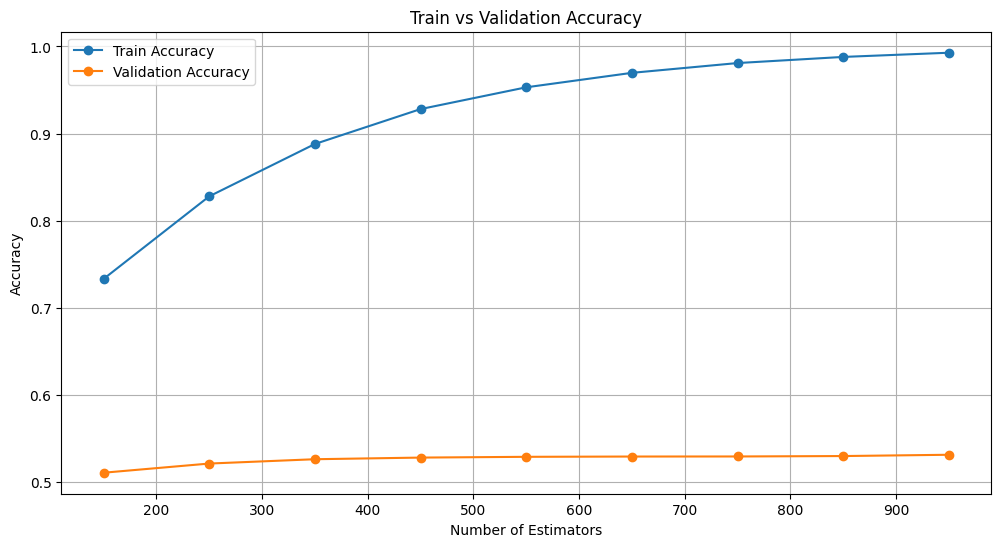

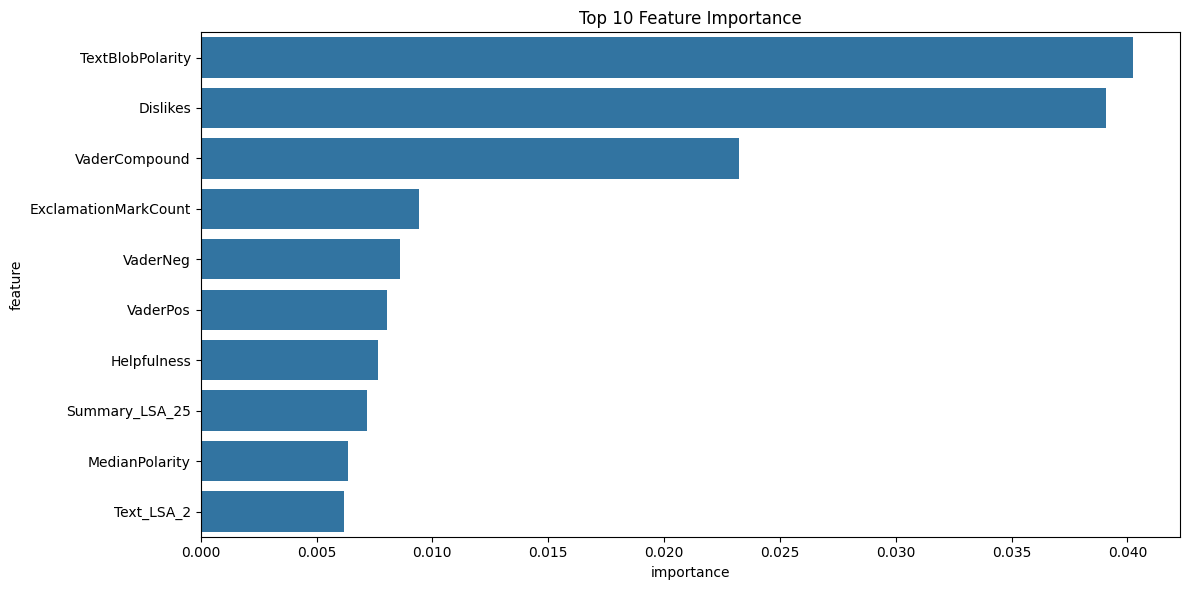

In [ ]:
# Drop unnecessary columns
columns_to_drop = ['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'ProcessedSummary', 'ProcessedText', 'Time']

X_train_processed = X_train.drop(columns=columns_to_drop)
X_val_processed = X_val.drop(columns=columns_to_drop)

# Function to track both train and validation accuracy
def evaluate_estimators():
    n_estimators_range = list(range(150, 1050, 100))
    train_accuracy = []
    val_accuracy = []

    for n_estimators in n_estimators_range:
        print(f"Training with {n_estimators} estimators...")

        classifier = xgb.XGBClassifier(
            n_estimators=n_estimators,
            tree_method='gpu_hist',
            device='cuda',
            num_class=5,
            learning_rate=0.05,
            max_depth=7,
            random_state=42
        )

        # Train and predict
        classifier.fit(X_train_processed, Y_train)

        # Get training accuracy
        Y_train_pred = classifier.predict(X_train_processed)
        train_acc = accuracy_score(Y_train, Y_train_pred)
        train_accuracy.append(train_acc)

        # Get validation accuracy
        Y_val_pred = classifier.predict(X_val_processed)
        val_acc = accuracy_score(Y_val, Y_val_pred)
        val_accuracy.append(val_acc)

    return classifier, n_estimators_range, train_accuracy, val_accuracy

# Plot train vs validation accuracy
classifier, n_estimators_range, train_accuracy, val_accuracy = evaluate_estimators()

plt.figure(figsize=(12, 6))
plt.plot(n_estimators_range, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(n_estimators_range, val_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Check distribution
plt.figure(figsize=(10, 6))
print("Dislikes statistics:")
print(X_train['Dislikes'].describe())
sns.histplot(X_train['Dislikes'])
plt.title('Distribution of Dislikes')
plt.show()

# Check correlation with target
print("\nCorrelation with Score:")
print(pd.DataFrame({
    'Score': Y_train,
    'Dislikes': X_train['Dislikes']
}).corr())

Training final model...
Making predictions...

Prediction range: 1 - 5
Prediction distribution:
Score
1    18155
2    22338
3    27074
4    55494
5    89131
Name: count, dtype: int64
Submission saved!


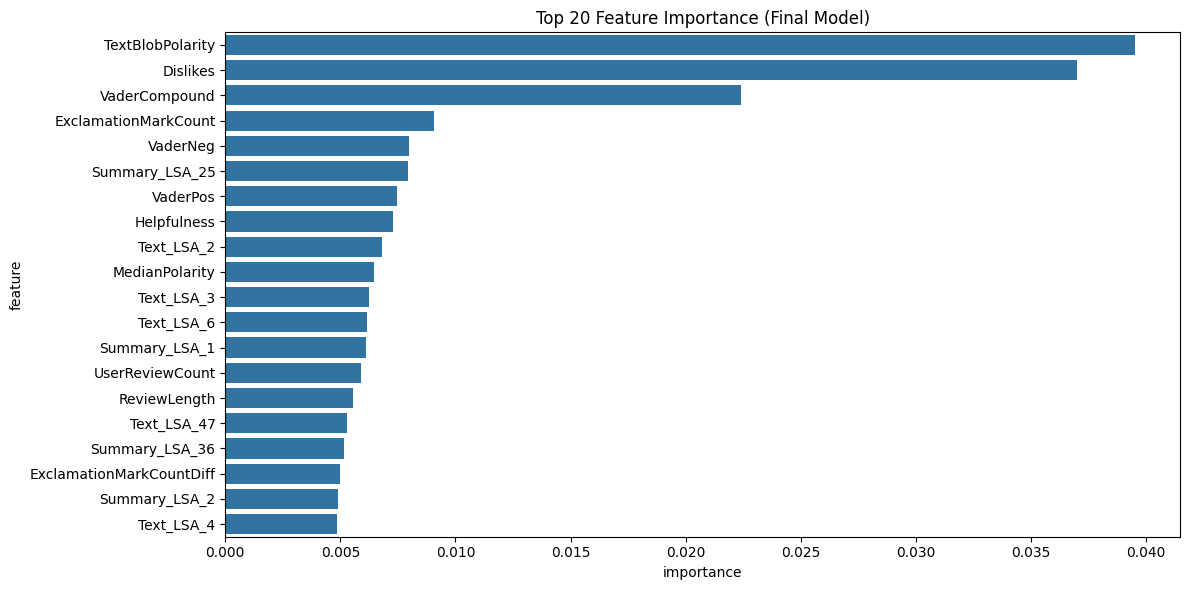

In [ ]:
# Process submission data consistently with training data
columns_to_drop = ['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'ProcessedSummary', 'ProcessedText', 'Time', 'Score']
X_submission_processed = X_test.drop(columns=columns_to_drop)


# Create final model with best parameters from GridSearchCV
final_model = xgb.XGBClassifier(
    n_estimators=550,
    tree_method='gpu_hist',
    device='cuda',
    num_class=5,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
)

# Train on full training data
print("Training final model...")
final_model.fit(X_train_processed, Y_train)

# Make predictions
print("Making predictions...")
predictions = final_model.predict(X_submission_processed)

# Create submission DataFrame (add 1 to convert back to 1-5 range)
submission = pd.DataFrame({
    'Id': X_test['Id'],
    'Score': predictions + 1  # Convert from 0-4 back to 1-5
})

# Verify prediction range
print("\nPrediction range:", submission['Score'].min(), "-", submission['Score'].max())
print("Prediction distribution:")
print(submission['Score'].value_counts().sort_index())

# Save submission
submission.to_csv("/content/drive/My Drive/Colab Notebooks/data/submission.csv", index=False)
print("Submission saved!")

# Optional: Plot feature importance for final model
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importance (Final Model)')
plt.tight_layout()
plt.show()